# Libraries Import

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform
import cv2
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
import os
import h5py
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, ReLU, DepthwiseConv2D, add
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Python version: 3.10.12
Tensorflow version: 2.12.0
Keras version: 2.12.0


#Data Preprocessing

In [ ]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
input_shape = x_train.shape

IMAGE_CHANNELS = 1

# print('Number_of_elements:', Number_of_elements)
# print('IMAGE_WIDTH:', IMAGE_WIDTH)
# print('IMAGE_HEIGHT:', IMAGE_HEIGHT)
# print('IMAGE_CHANNELS:', IMAGE_CHANNELS)
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255
print(input_shape)
print(x_train_normalized.shape)

11490434/11490434 [==============================] - 1s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
(60000, 28, 28)
(60000, 28, 28)


In [ ]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(Number_of_elements, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train.shape
IMAGE_CHANNELS = 1

print('Number_of_elements:', Number_of_elements)
print('IMAGE_WIDTH:', IMAGE_WIDTH)
print('IMAGE_HEIGHT:', IMAGE_HEIGHT)
print('IMAGE_CHANNELS:', IMAGE_CHANNELS)

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
Number_of_elements: 60000
IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


In [ ]:
print('Initial x_train : ', x_train.shape) # (60000, 28, 28)
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32,32])
print('Final x_train : ', x_train.shape) # (60000, 32, 32, 1)

print('Initial x_test : ', x_test.shape) # (60000, 28, 28)
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32,32])
print('Final x_test : ' ,x_test.shape) # (60000, 32, 32, 1)

Initial x_train :  (60000, 28, 28)
Final x_train :  (60000, 32, 32, 1)
Initial x_test :  (10000, 28, 28)
Final x_test :  (10000, 32, 32, 1)


In [ ]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255
x_train_normalized = np.repeat(x_train, 3, axis=3)
x_test_normalized = np.repeat(x_test, 3, axis=3)

In [ ]:
print(x_train_normalized.shape)
print(x_test_normalized.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


# Model Architecture (MobilenetV2)

In [ ]:
def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name =    prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x
def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name = prefix +'dw_relu')(x)
    return x
def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels,kernel_size = 1,   padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x

In [ ]:
def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
       y = add([x,y])
    return y

In [ ]:
# input = Input (input_shape)
# x = Conv2D(32,3,strides=(2,2),padding='same', use_bias=False)(input)
# x = BatchNormalization(name='conv1_bn')(x)
# x = ReLU(6, name='conv1_relu')(x)

In [ ]:
# x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)

In [ ]:
# x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
# x = BatchNormalization(name='last_bn')(x)
# x = ReLU(6,name='last_relu')(x)
# x = GlobalAveragePooling2D(name='global_average_pool')(x)
# output = Dense(n_classes=10,activation='softmax')(x)

In [ ]:
def MobileNetV2(input_image=(32,32,3), n_classes=10):
    input = Input (input_image)
    x = Conv2D(32,3,strides=(2,2),padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)
    # 17 Bottlenecks
    x = depthwise_block(x,stride=1,block_id=1)
    x = projection_block(x, out_channels=16,block_id=1)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)
    x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    output = Dense(n_classes,activation='softmax')(x)
    model = Model(input, output)
    return model

In [ ]:
model = MobileNetV2(input_image=(32, 32, 3), n_classes=10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 32)   128         ['conv2d[0][0]']                 
                                                                                                  
 conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['conv1_bn[0][0]']               
                                                                                              

# Training

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
training_history = model.fit(x_train_normalized,
     y_train,
     epochs=50,
     batch_size = 256,
     validation_data=(x_test_normalized, y_test),
 )

Epoch 1/50
235/235 [==============================] - 89s 116ms/step - loss: 0.4150 - accuracy: 0.8756 - val_loss: 2.8602 - val_accuracy: 0.1032
Epoch 2/50
235/235 [==============================] - 23s 98ms/step - loss: 0.0924 - accuracy: 0.9745 - val_loss: 1.1997 - val_accuracy: 0.6114
Epoch 3/50
235/235 [==============================] - 20s 84ms/step - loss: 0.0782 - accuracy: 0.9791 - val_loss: 0.3903 - val_accuracy: 0.9159
Epoch 4/50
235/235 [==============================] - 20s 84ms/step - loss: 0.0599 - accuracy: 0.9837 - val_loss: 0.0726 - val_accuracy: 0.9831
Epoch 5/50
235/235 [==============================] - 20s 83ms/step - loss: 0.3189 - accuracy: 0.9228 - val_loss: 3.4236 - val_accuracy: 0.8072
Epoch 6/50
235/235 [==============================] - 20s 84ms/step - loss: 0.1047 - accuracy: 0.9699 - val_loss: 1.1915 - val_accuracy: 0.7774
Epoch 7/50
235/235 [==============================] - 21s 88ms/step - loss: 0.1378 - accuracy: 0.9623 - val_loss: 0.2834 - val_accuracy

# Evaluation

min Test loss:  0.02935292385518551
max Test accuracy:  0.9916999936103821


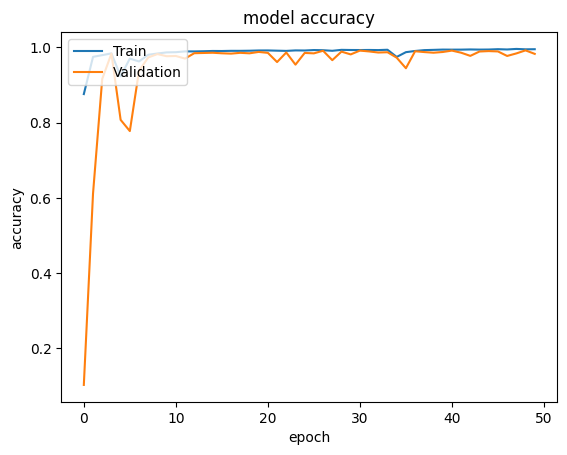

NameError: ignored

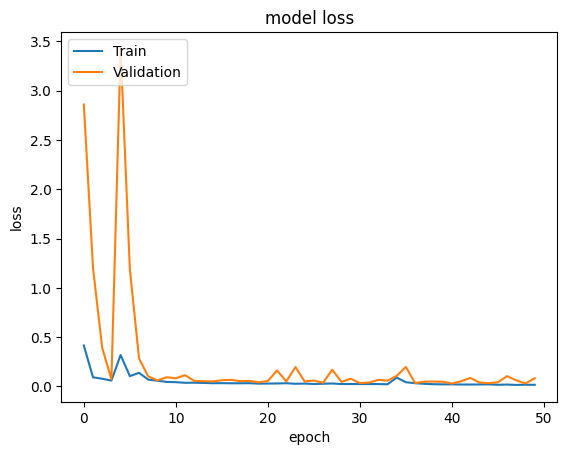

In [ ]:
import matplotlib.pyplot as plt

print('min Test loss: ', min(training_history.history['val_loss']))
print('max Test accuracy: ', max( training_history.history['val_accuracy']))

# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/mobilenet/mnist_mobilenet_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/mobilenet/mnist_mobilenet_loss.png')
plt.show()

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

313/313 [==============================] - 3s 7ms/step
Confusion Matrix:
[[ 978    1    0    0    0    0    1    0    0    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [  47    3  980    0    0    0    0    2    0    0]
 [   0    0    2 1003    0    4    0    1    0    0]
 [   1    4    0    0  967    0    0    0    0   10]
 [   2    1    0    3    0  885    1    0    0    0]
 [   6    3    0    0    2    5  942    0    0    0]
 [   1    8    5    0    0    0    0 1013    0    1]
 [   4    3    4    4    0    3    1    1  949    5]
 [   7    1    0    4   10   13    0    1    0  973]]


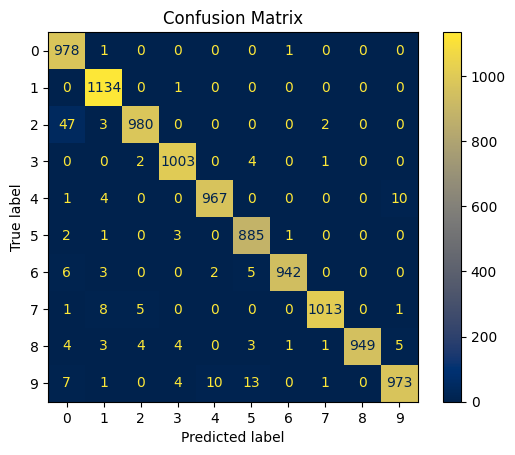

In [ ]:
y_pred = model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='cividis')
plt.title("Confusion Matrix")
plt.savefig('mnist_mobilenet_cm.png')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, f1_score, recall_score
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Precision: 0.982841512072317
F1 Score: 0.9824253237317087
Recall: 0.9824
